# Redesigning John Snow’s 1854 Cholera Map (Interactive)

**Goal:** Reimagine the classic cholera map with modern, interactive methods—keeping the real data, but letting people explore it. The point isn’t to “beat” the original; it’s to reveal new facets (time, detail-on-demand, alternative views) for a modern audience.


In [1]:

import pandas as pd
import numpy as np
import shapely
import folium
import plotly.express as px
import seaborn as sns, matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from folium import plugins
from folium.plugins import HeatMap, FastMarkerCluster
from itertools import combinations

deaths = pd.read_csv('data/deaths.csv')
pumps = pd.read_csv('data/pumps.csv')
deaths.head()

death_count   latitude  longitude
0            1  51.513418  -0.137930
1            1  51.513418  -0.137930
2            1  51.513418  -0.137930
3            1  51.513361  -0.137883
4            1  51.513361  -0.137883

## Design Goals
- **Explore, not just expose:** Pan/zoom/hover to get exact locations and counts.
- **Add time:** See the outbreak unfold day by day (slider/animation).
- **Context layers:** Toggle pumps and an optional heatmap on a clean basemap.
- **Test a stretch idea:** A quick 3D space-time view; keep if useful.
- **Keep it clear:** Minimal clutter, short labels, commented code.


# Inspiration from class 
I am putting the given codes here to get some inspiration to construct my own examples, being able to see the outputs visually will help me set a clearer way to design the integrated graphs.

In [2]:
locations_deaths = deaths[['latitude', 'longitude']]
locations_pumps = pumps[['latitude', 'longitude']]

deaths_list = locations_deaths[['latitude', 'latitude']].values.tolist()
pumps_list = locations_pumps[['latitude', 'latitude']].values.tolist()

In [3]:
map = folium.Map(location=[51.51333282562678, -0.1368429489745336], tiles='Cartodb Positron', zoom_start=17)
for point in range(0, len(locations_deaths)):
    folium.CircleMarker(deaths_list[point], radius=8, color='black', fill=True, fill_color='black', opacity = 0.4).add_to(map)
map1 = map
for point in range(0, len(locations_pumps)):
    folium.Marker(pumps_list[point], popup=pumps['pump_name'][point]).add_to(map1)

# Display the map
map1

In [4]:
FastMarkerCluster(data=list(zip(deaths['latitude'].values, deaths['longitude'].values))).add_to(map)
folium.LayerControl().add_to(map)
map

### Baseline 2D Map (Why start here?)
This recreates Snow’s core insight—deaths cluster near the Broad Street pump—using the original structure. It also shows pain points (overplotting, hard to get exact counts) that interactivity can solve.


In [5]:
for index, row in deaths.iterrows():

    folium.CircleMarker(location=(row["latitude"],
                                  row["longitude"]),
                        radius= row['death_count']*10,
                        color='#FA8072',
                        fillOpacity=0.9,
                        fill=True).add_to(map)
map

### Heatmap Layer
A modern density view: quickly shows the epicenter near Broad Street.  
Kept optional to preserve detail visibility.


In [6]:
base_map = folium.Map(location=[51.5132119,-0.13666], tiles='https://watercolormaps.collection.cooperhewitt.org/tile/watercolor/{z}/{x}/{y}.jpg',attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under CC BY SA.' , zoom_start=16)

for i,row in pumps.iterrows():
    folium.Marker([row['latitude'],row['longitude']], popup=row['pump_name']).add_to(base_map)
base_map
heat_data = [[row['latitude'],row['longitude']] for index, row in locations_deaths.iterrows()]

HeatMap(heat_data).add_to(base_map)
base_map

# Trial Redesign
The heat map looks amazing, I wonder what can I do to add some features on top. I had an idea of making network connections between the pumps so maybe I could come up with some correlations between the pumps and the death locations.

### Warning: might need to run cell below again to see the network

In [14]:
PUMP_LAT = "latitude"
PUMP_LON = "longitude"
LABEL_COL = "pump_name"


pumps_clean = pumps.dropna(subset=[PUMP_LAT, PUMP_LON]).copy()


pump_network = folium.FeatureGroup(name="Pump Network", show=True)


for (i1, row1), (i2, row2) in combinations(pumps_clean.iterrows(), 2):
    folium.PolyLine(
        locations=[
            (row1[PUMP_LAT], row1[PUMP_LON]),
            (row2[PUMP_LAT], row2[PUMP_LON])
        ],
        color="#0077be",
        weight=5,
        opacity=0.6
    ).add_to(pump_network)


for _, row in pumps_clean.iterrows():
    folium.Marker(
        [row[PUMP_LAT], row[PUMP_LON]],
        popup=row.get(LABEL_COL, "Pump"),
        icon=folium.Icon(color="red", icon="tint", prefix="fa")
    ).add_to(pump_network)

pump_network.add_to(base_map)

folium.LayerControl(collapsed=False).add_to(base_map)

base_map


# Feedback on heatmap network
I have a complete graph from graph theory using the pumps as vertices and the connections between each other as edges. It look like a spider web surrounding the death heat map.\
However I couln't much integration on top of the original heatmap, the network just covers over the half of the region but does not produce a similar shape compared with the heatmap.\
I would like to think about other ways to prove this correlation

# Heatmap in Snow's style
The following heatmap is different than what's given in the example, it's a redesign to snow's original graph\
\
Insead of using stacks per house hold, I use heat map to represent the number of death per location, makes a modern approach in the orignal style

In [8]:
fig_heat = px.density_mapbox(
    deaths, lat='latitude', lon='longitude', radius=10,
    center={"lat": 51.513, "lon": -0.137}, zoom=16,
    mapbox_style="carto-positron",
    title="Cholera Death Density Heatmap",
    height=1000,
    width=1000
)
fig_heat.show()


# Distance to pumps
Showing distance from deah location to nearest pumps and comparing them together would be a great idea to show a linear relation between these two data.\
\
To increase interactivity, I used plotly to show each bar's stats, without explicitly showing those on the graph, which also makes it look better visually.

In [9]:
DEATH_X = "longitude"
DEATH_Y = "latitude"
PUMP_X  = "longitude"
PUMP_Y  = "latitude"


for col in [DEATH_X, DEATH_Y]:
    deaths[col] = pd.to_numeric(deaths[col], errors="coerce")
for col in [PUMP_X, PUMP_Y]:
    pumps[col] = pd.to_numeric(pumps[col], errors="coerce")

deaths_clean = deaths.dropna(subset=[DEATH_X, DEATH_Y]).copy()
pumps_clean  = pumps.dropna(subset=[PUMP_X, PUMP_Y]).copy()


if "distance_to_pump" not in deaths_clean.columns or deaths_clean["distance_to_pump"].isna().all():
    pts = deaths_clean[[DEATH_X, DEATH_Y]].to_numpy()
    cts = pumps_clean[[PUMP_X, PUMP_Y]].to_numpy()


    dists = np.sqrt(((pts[:, None, :] - cts[None, :, :])**2).sum(axis=2))
    nearest_idx = dists.argmin(axis=1)
    min_dist = dists[np.arange(dists.shape[0]), nearest_idx]

    deaths_clean["nearest_pump"] = nearest_idx

    pump_name_col = None
    for c in pumps_clean.columns:
        if c.lower() in ("pump_name", "name", "label"):
            pump_name_col = c
            break
    if pump_name_col:
        deaths_clean["nearest_pump_name"] = pumps_clean.iloc[nearest_idx][pump_name_col].to_numpy()

    deaths_clean["distance_to_pump"] = min_dist


    deaths.loc[deaths_clean.index, ["nearest_pump", "distance_to_pump"]] = \
        deaths_clean[["nearest_pump", "distance_to_pump"]].to_numpy()
    if "nearest_pump_name" in deaths_clean.columns:
        deaths.loc[deaths_clean.index, "nearest_pump_name"] = deaths_clean["nearest_pump_name"].to_numpy()


import plotly.express as px
fig_dist = px.histogram(
    deaths_clean.dropna(subset=["distance_to_pump"]),
    x="distance_to_pump",
    nbins=30,
    title="Distance to Nearest Pump (Deaths)"
)
fig_dist.update_layout(
    xaxis_title="Distance (map units of your dataset)",
    yaxis_title="Number of deaths"
)
fig_dist.show()

# Enhanced pump distance
I added a few features to show a better relations on the pump distance.
 - **Firt graph** is just the same graph but with extended x-limit to show stronger correlation and point out the outlier.
 - **Second graph** is the same data in line chart, which does not seemed to help a lot here. And that's why I have a third graph
 - **Third graph** added trendline to the data, so it shows a normal distribution on the data. One can infer the correlation between them

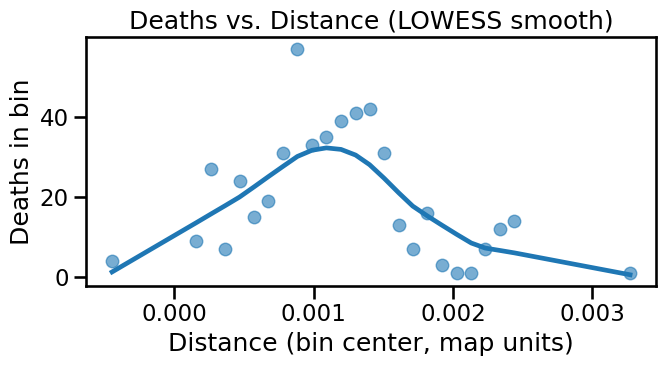

In [10]:

df = deaths_clean.dropna(subset=["distance_to_pump"]).copy()


#pick either: (A) max*1.25  or (B) 99th percentile * 1.1 to reduce outlier impact.
max_dist_ext = max(df["distance_to_pump"].max() * 1.25,
                   df["distance_to_pump"].quantile(0.99) * 1.10)


fig_hist_wide = px.histogram(
    df,
    x="distance_to_pump",
    nbins=60, 
    range_x=[0, max_dist_ext],
    title="Deaths by Distance to Nearest Pump (Extended Domain)"
)
fig_hist_wide.update_layout(
    xaxis_title="Distance to Nearest Pump (map units)",
    yaxis_title="Number of deaths",
    bargap=0.03
)
fig_hist_wide.show()


n_bins = 40
bins = np.linspace(0, max_dist_ext, n_bins + 1)
labels = pd.IntervalIndex.from_breaks(bins, closed="left")
df["dist_bin"] = pd.cut(df["distance_to_pump"], bins=bins, include_lowest=True)

binned = (
    df.groupby("dist_bin", observed=True)
      .size()
      .rename("death_count")
      .reset_index()
)


binned["dist_center"] = binned["dist_bin"].apply(lambda iv: (iv.left + iv.right) / 2.0)


fig_binned = px.scatter(
    binned,
    x="dist_center", y="death_count",
    title="Deaths vs. Distance to Nearest Pump (Binned)",
    labels={"dist_center": "Distance (bin center, map units)", "death_count": "Deaths in bin"}
)

fig_binned.update_traces(mode="lines+markers")
fig_binned.show()


sns.set_context("talk")
plt.figure(figsize=(7,4))
sns.regplot(x="dist_center", y="death_count", data=binned, lowess=True, scatter_kws={"alpha":0.6})
plt.title("Deaths vs. Distance (LOWESS smooth)")
plt.xlabel("Distance (bin center, map units)")
plt.ylabel("Deaths in bin")
plt.tight_layout()
plt.show()


# Map over time
I also have the date in the data file, I think it would be cool and helpful to add it.\
\
The following graph shows a map with death locations showing up by time, click to play.\
\
One could see how many death each day and which day has most death, and where.

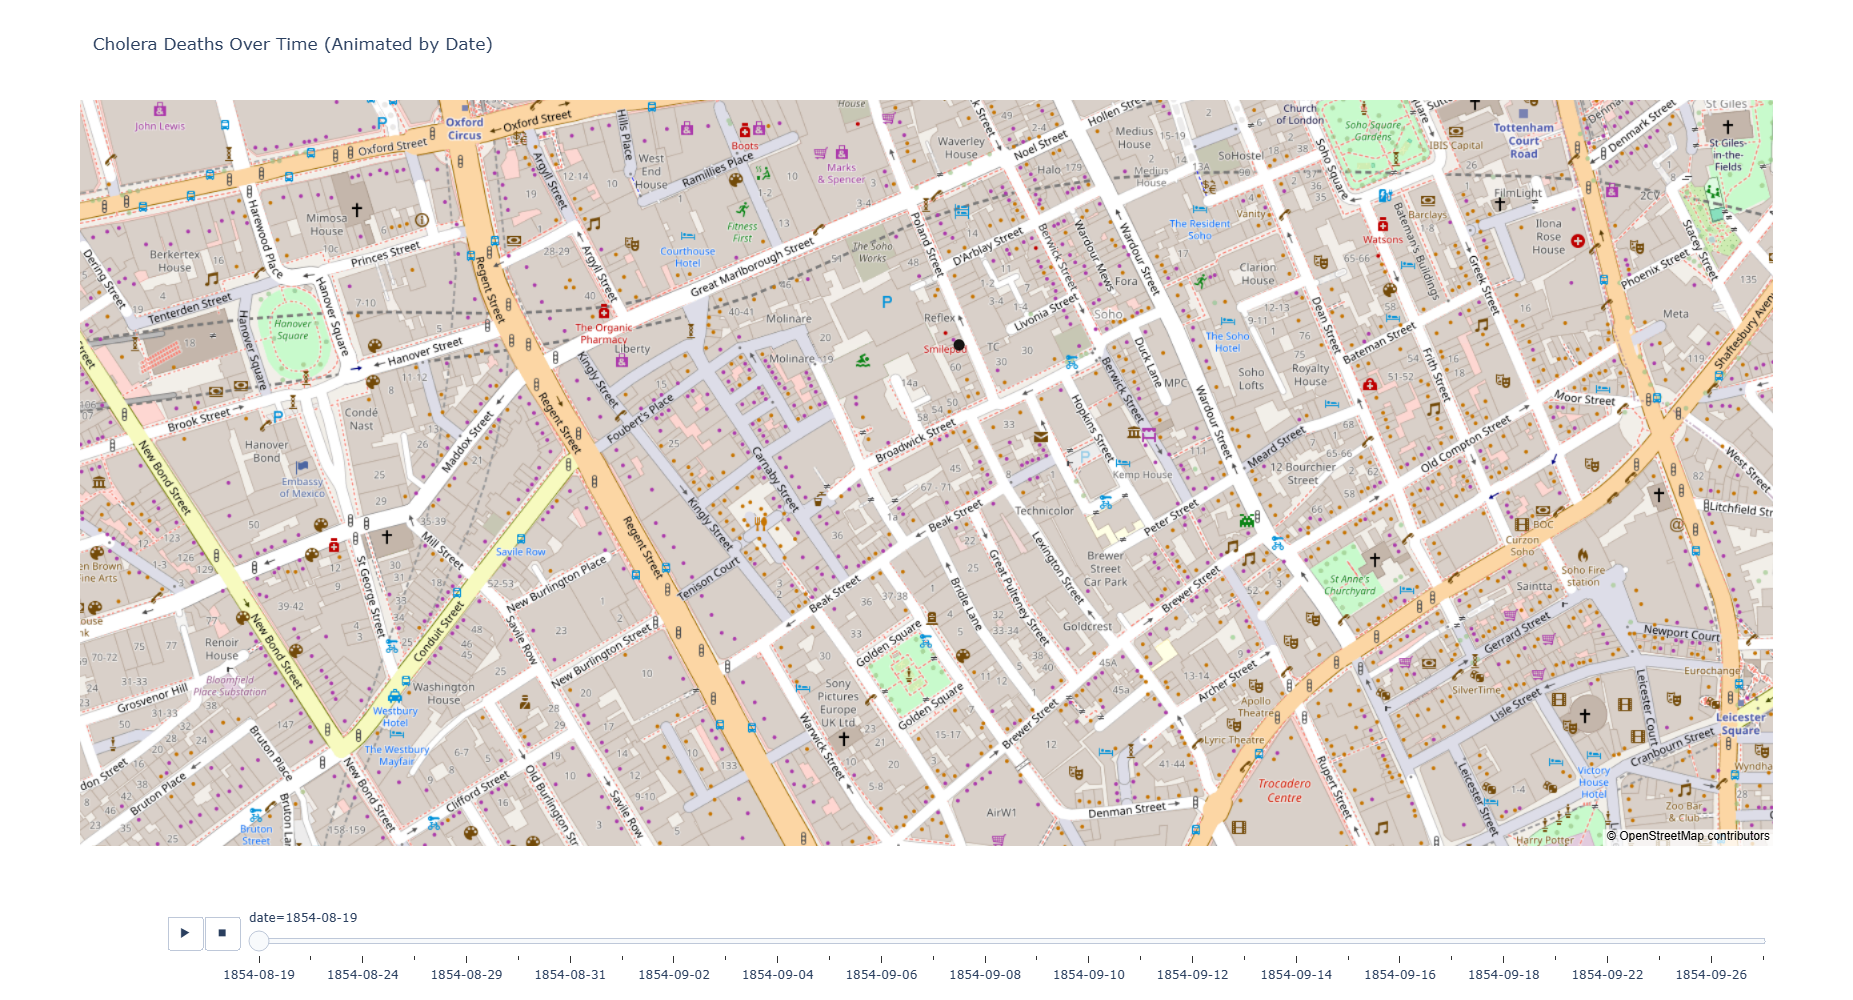

In [15]:
dates = pd.read_csv('data/snow_dates.csv')
total_deaths = len(deaths)

dates['alloc'] = (dates['deaths'] * total_deaths / dates['deaths'].sum()).round().astype(int)


death_points = deaths.sample(frac=1, random_state=42).reset_index(drop=True)
date_labels = []
for _, row in dates.iterrows():
    date_labels += [row['date']] * int(row['alloc'])

death_points = death_points.iloc[:len(date_labels)].copy()
death_points['date'] = date_labels[:len(death_points)]


fig_anim = px.scatter_mapbox(
    death_points, lat='latitude', 
    lon='longitude', 
    color_discrete_sequence=['black'],
    animation_frame='date', 
    center={"lat": 51.513, "lon": -0.137}, 
    zoom=16,
    title="Cholera Deaths Over Time (Animated by Date)", 
    height=1000,
    width=1000
)

fig_anim.update_traces(
    marker=dict(
        size=12,
        color='rgba(0,0,0,0.9)',
        allowoverlap=True
    )
)

fig_anim.update_layout(mapbox_style="open-street-map")
fig_anim.show()


# Death to nearest pump
The following bar chart shows the number of death to nearest pump. We can clearly see which pump is closer to the higher death location.\
Instead of showing on a map, a discrete linear relationship is shown in the graph, people and tell an interesting story on which pump has more death.

In [12]:
pump_coords = pumps[['latitude', 'longitude']].values

pump_names = pumps['pump_name'].tolist()
deaths['nearest_pump'] = [
    pump_names[np.argmin((pump_coords[:,0] - lat)**2 + (pump_coords[:,1] - lon)**2)]
    for lat, lon in zip(deaths['latitude'], deaths['longitude'])
]

count_by_pump = deaths['nearest_pump'].value_counts().reset_index()
count_by_pump.columns = ['pump_name', 'death_count']

fig_bar = px.bar(
    count_by_pump, x='pump_name', y='death_count',
    title="Cholera Deaths Associated with Each Pump (nearest pump regions)"
)
fig_bar.update_layout(xaxis_title="Pump", yaxis_title="Number of Deaths")
fig_bar.show()


# 3D Approach
The following is my final approach as an experiment, and I tried do it in a 3D way. Using the coordinates and the death dates.\
One could intepret it as 3D version of the time map, but shown with added z-axis.\
It is interesting but does not look very good, as I cannot relate with the real map (could be added in the future). Some information can be understand in the graph, e.g. people can see the density of death and time together. However I believe is rather complex and hard to deliver a point.

In [13]:
# Prepare data for 3D plot: use numeric day count for z-axis
death_points['day_num'] = (pd.to_datetime(death_points['date']) - pd.to_datetime('1854-08-19')).dt.days

fig3d = px.scatter_3d(
    death_points, x='longitude', y='latitude', z='day_num',
    color='day_num', color_continuous_scale='Viridis',
    title="Cholera Deaths in Space and Time (3D)",
    labels={"day_num": "Days since Aug 19, 1854"},
    height=800,
    width=800
)
fig3d.update_traces(marker=dict(size=3))
fig3d.show()


## Final Reflection
- Keep: 2D interactive map + time slider; clear and accurate.
- Optional: Heatmap and distance plots for extra insights.
- Drop: 3D—fun, but less precise.

**Takeaway:** The redesign preserves Snow’s key insight while letting modern users explore space, time, and relationships interactively.\
\
Each of these modifications alters the visualization's structure and register. For instance, an interactive or animated map can be more persuasive to the public by showing the outbreak's spread, while analytical charts can make the case more rigorous to a scientific audience. It's also an opportunity for creative storytelling. In summary, modern techniques radically extend what Snow's cholera map can do. We can maintain the core message that cholera cases clustered around a contaminated pump, but deliver it in interactive, dynamic, and quantitative ways that suits different medias and audiences.
